# Keras liner regression
Fit values from smog sensor without dryer to dryer version

### Imports

In [2]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn import preprocessing
from tensorflow.keras.optimizers import Adam

### Config GPU

In [3]:
print(f'Keras version: {keras.__version__}')

gpu_info = tf.config.list_physical_devices("GPU")
print(f'Num GPUs: {len(gpu_info)}')

if len(gpu_info) > 0:
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True

    gpus = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)

Keras version: 2.7.0
Num GPUs: 1


# Read and show data

In [4]:
dataset = pd.read_csv('../dataset/smog_part1.csv', index_col = 0)
dataset = dataset[dataset['humiditySht'] >= 60]

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18683 entries, 0 to 26455
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              18683 non-null  int64  
 1   date               18683 non-null  object 
 2   pm25_x             18683 non-null  float64
 3   pm10_x             18683 non-null  float64
 4   pressure           18683 non-null  int64  
 5   temperatureHeca_x  18683 non-null  float64
 6   humidityHeca_x     18683 non-null  int64  
 7   pm25_y             18683 non-null  float64
 8   pm10_y             18683 non-null  float64
 9   temperatureSht     18683 non-null  float64
 10  humiditySht        18683 non-null  int64  
 11  temperatureHeca_y  18683 non-null  float64
 12  humidityHeca_y     18683 non-null  int64  
 13  pm25_ratio         18683 non-null  float64
 14  pm10_ratio         18683 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.3+ MB


In [6]:
dataset.describe()

,index,pm25_x,pm10_x,pressure,temperatureHeca_x,humidityHeca_x,pm25_y,pm10_y,temperatureSht,humiditySht,temperatureHeca_y,humidityHeca_y,pm25_ratio,pm10_ratio
count,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000,18683.000000
mean,15458.855965,9.273489,16.713617,990.087620,19.568726,57.279505,10.599802,20.797286,15.802831,76.176845,16.659685,69.671091,1.156769,1.220479
std,7573.798736,7.164696,12.974271,5.929156,4.782299,3.032780,8.127336,16.839288,4.944176,8.306881,4.843462,8.834772,0.333659,0.360875
min,1.000000,0.600000,2.400000,971.000000,5.700000,38.000000,0.400000,1.000000,1.100000,60.000000,2.100000,50.000000,0.070000,0.060000
25%,9203.500000,4.200000,8.800000,986.000000,16.200000,55.000000,4.600000,9.800000,12.100000,70.000000,13.000000,63.000000,1.000000,1.020000
50%,16765.000000,7.400000,13.100000,990.000000,19.200000,58.000000,8.500000,15.800000,15.700000,77.000000,16.600000,70.000000,1.110000,1.180000
75%,21978.500000,12.000000,20.100000,994.000000,23.200000,60.000000,14.400000,26.300000,19.400000,83.000000,20.200000,76.000000,1.270000,1.370000
max,26681.000000,93.100000,267.400000,1005.000000,36.000000,89.000000,111.900000,278.800000,30.600000,98.000000,31.000000,96.000000,9.910000,5.020000


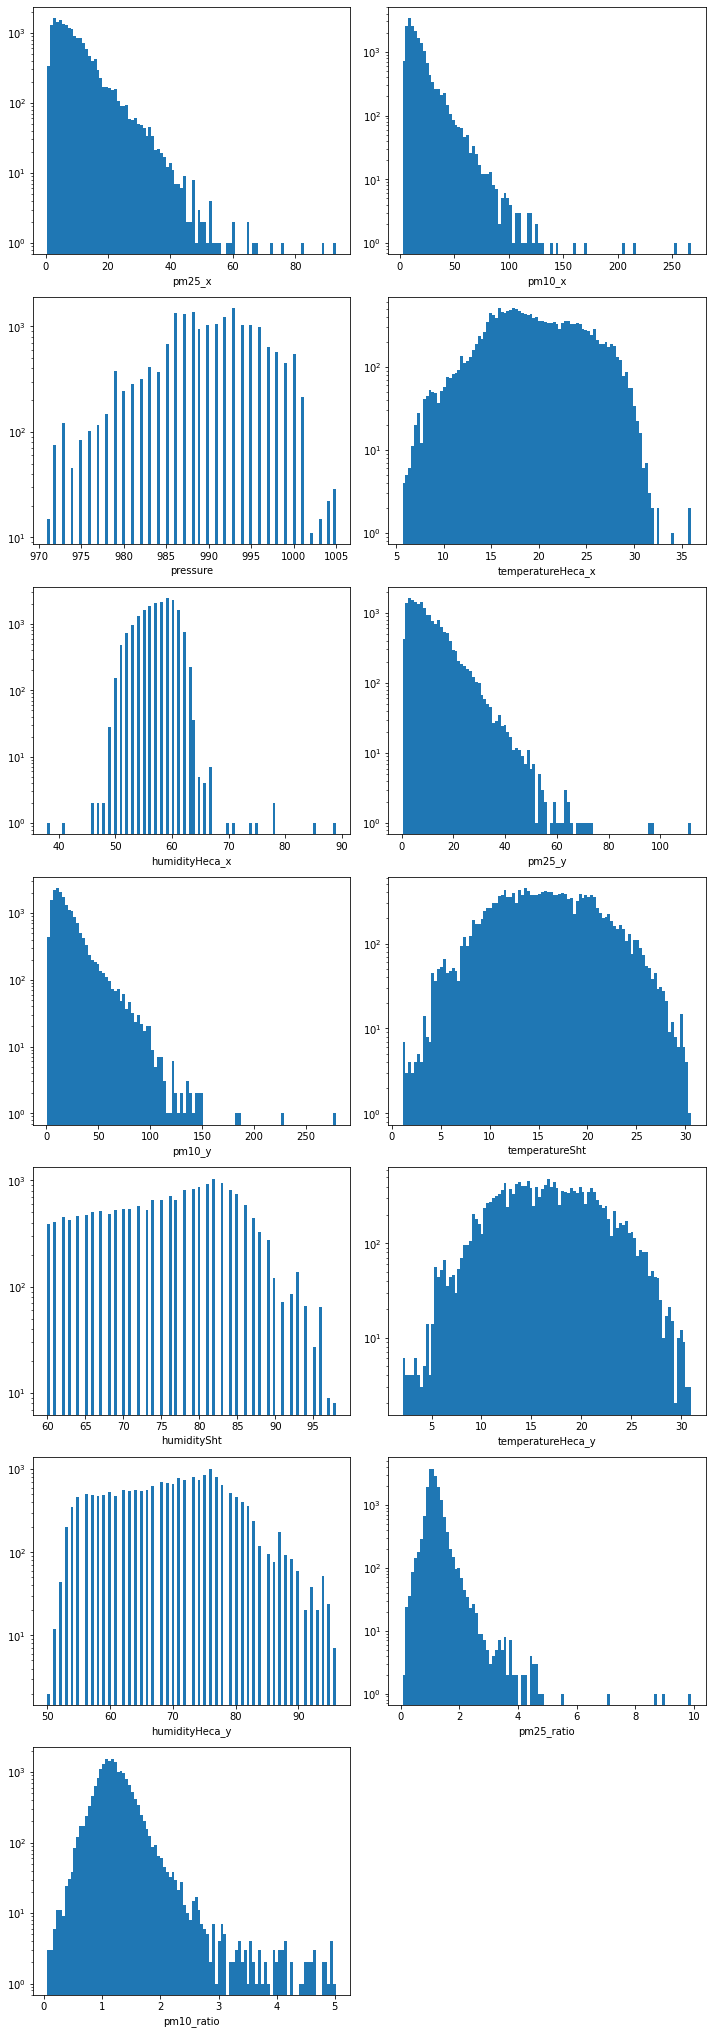

In [7]:
fig = plt.figure(figsize = (10, 40))

for i, key in enumerate(dataset.keys()[2:]):
    plt.subplot(10, 2, i+1)
    plt.hist(dataset[key], bins = 100)
    plt.yscale('log', nonpositive = 'clip')
    plt.xlabel(key)

fig.tight_layout()
plt.show()

In [8]:
dataset[['pm25_ratio', 'pm10_ratio', 'pm25_y', 'pm10_y', 'pressure', 'temperatureSht', 'humiditySht']]

,pm25_ratio,pm10_ratio,pm25_y,pm10_y,pressure,temperatureSht,humiditySht
0,0.73,1.05,13.8,24.4,986,6.1,72
1,0.86,1.31,14.4,27.0,986,5.9,74
2,0.69,1.18,15.1,29.1,986,5.7,75
3,0.83,1.31,18.0,33.7,986,5.7,76
4,0.76,1.22,19.0,36.0,986,5.5,77
...,...,...,...,...,...,...,...
26451,1.08,1.08,21.5,45.7,993,9.8,83
26452,1.58,1.78,24.0,52.4,993,9.7,83
26453,1.38,1.43,20.0,40.5,993,9.6,83
26454,0.96,1.01,16.1,32.5,993,9.6,83


<AxesSubplot:>

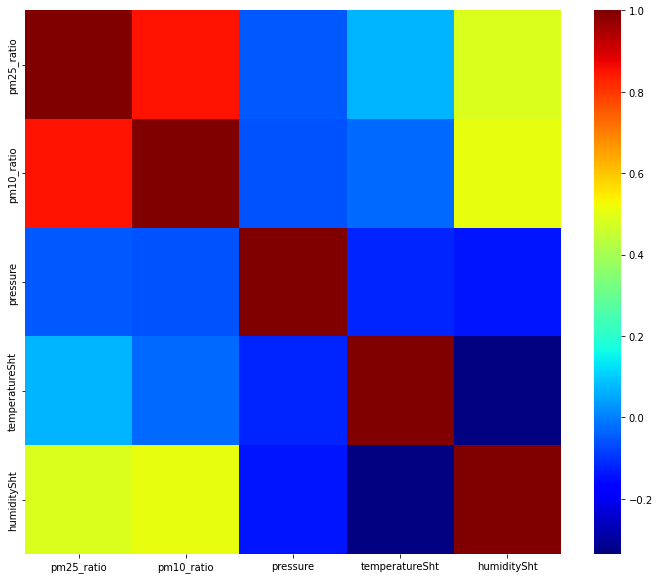

In [9]:
plt.figure(figsize = (12, 10))
sns.heatmap(dataset[['pm25_ratio', 'pm10_ratio', 'pressure', 'temperatureSht', 'humiditySht']].corr(),
            cmap = 'jet')

# Train and test split

Split data for train and test and normalize them

In [10]:
dataset = dataset[['pm25_x', 'pm25_y', 'temperatureSht', 'humiditySht', 'pressure']]

Y = dataset['pm25_x']
X = dataset.drop('pm25_x', axis = 1)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 0)

In [12]:
scaler = preprocessing.StandardScaler().fit(x_train)
y_scaler = max(y_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y_train = y_train / y_scaler

### Model

In [13]:
model = models.Sequential()

model.add(layers.Dense(64, activation = 'relu', input_shape = (x_train.shape[1],)))
model.add(layers.Dense(80, activation = 'relu'))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

model.compile(optimizer = Adam(learning_rate=0.0038), loss = 'mae', metrics = ['mae'])

history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2, batch_size = 256)

Epoch 1/10
47/47 [==============================] - 1s 8ms/step - loss: 0.0387 - mae: 0.0387 - val_loss: 0.0134 - val_mae: 0.0134
Epoch 2/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0151 - mae: 0.0151 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 3/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0137 - mae: 0.0137 - val_loss: 0.0117 - val_mae: 0.0117
Epoch 4/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0113 - val_mae: 0.0113
Epoch 5/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0126 - mae: 0.0126 - val_loss: 0.0110 - val_mae: 0.0110
Epoch 6/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0123 - mae: 0.0123 - val_loss: 0.0105 - val_mae: 0.0105
Epoch 7/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0122 - mae: 0.0122 - val_loss: 0.0106 - val_mae: 0.0106
Epoch 8/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0120 - mae: 0.01

In [14]:
history_dict = history.history

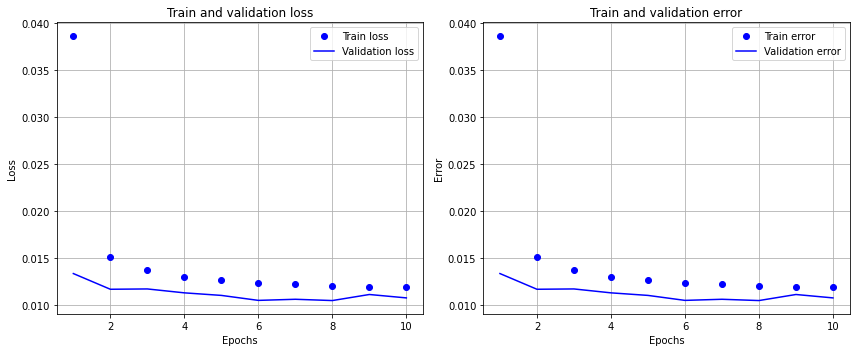

In [15]:
fig = plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label = 'Train loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


plt.subplot(1, 2, 2)
mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs, mae, 'bo', label = 'Train error')
plt.plot(epochs, val_mae, 'b', label = 'Validation error')
plt.title('Train and validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

fig.tight_layout()
plt.show()

# Results

In [16]:
test_loss, test_err = model.evaluate(x_test, y_test)

117/117 [==============================] - 0s 2ms/step - loss: 9.1259 - mae: 9.1259


In [17]:
print('test_err:', test_err)

test_err: 9.125890731811523


In [18]:
y_pred = model.predict(x_test).reshape(-1,) * y_scaler

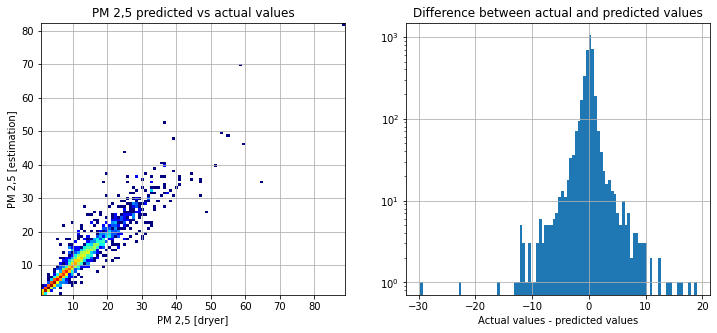

In [19]:
fig = plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.hist2d(y_test, y_pred, bins= 100, cmap = 'jet', norm = matplotlib.colors.LogNorm())
plt.xlabel('PM 2,5 [dryer]')
plt.ylabel('PM 2,5 [estimation]')
plt.title('PM 2,5 predicted vs actual values')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(y_pred - y_test, bins = 100)
plt.yscale('log')
plt.xlabel('Actual values - predicted values')
plt.title('Difference between actual and predicted values')
plt.grid(True)
plt.show()

fig.tight_layout()
plt.show()

In [21]:
r2 = r2_score(y_test, y_pred) * 100
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('R2: ', r2)
print('MSE: ', mse)
print('MAE: ', mae)

R2:  92.10326347761156
MSE:  4.135526318439138
MAE:  1.0239480517399895
